## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx 

import folium
import json
import geopandas as gpd
from shapely.geometry import LineString
import json
import heapq
from collections import defaultdict, deque
import queue

import random
import os 

## Data

In [2]:
df_links = pd.read_csv("data/IC_NETWORK/df_links.csv") 
df_distances = pd.read_csv("data/distance_matrix.csv") 
df_od = pd.read_csv("data/od_df.csv") 

In [3]:
df_links.start_node.unique()

array(['Zürich HB', 'Winterthur', 'Basel SBB', 'Fribourg/Freiburg',
       'Thun', 'Lugano Nord', 'Olten', 'Biel/Bienne', 'Lausanne', 'Zug',
       'Luzern', 'Genève'], dtype=object)

In [4]:
df_links.head()

,start_node,end_node,distance [m],IC_lines
0,Zürich HB,Chur,116075.402,IC3
1,Zürich HB,Winterthur,26787.367,"IC5, IC81"
2,Zürich HB,Baden,22587.175,IC3
3,Zürich HB,Bern,120492.589,"IC1, IC8, IC81"
4,Zürich HB,Zürich Oerlikon,5368.417,IC1


In [5]:
map = df_distances.columns[1:].to_list()

df_od['org'] = df_od['org'].map(lambda x: map[x])
df_od['dest'] = df_od['dest'].map(lambda x: map[x])

df_od.head()

,od_id,org,dest,q
0,0,Bern,Basel SBB,3671.0
1,1,Bern,Lausanne,1935.0
2,2,Bern,Luzern,9477.0
3,3,Bern,St. Gallen,924.0
4,4,Bern,Winterthur,3344.0


### Data manipulation

To correctly model the network with transfers, we decided to model the transfers between lines at a station as seperate edges. By doing this we can have full control over transfer costs, line headways, ...

Each station - line pair is modeled as a seperate node in the network, to change lines at a node there is an additional edge to represent the transfer. 

In [6]:
# Function to split multiple train lines and create individual connections
def process_multi_line_connections(df_links):

    """Expand rows with multiple train lines into individual connections"""
    
    rows = []
    
    for _, row in df_links.iterrows():
        # Check if there are multiple lines (comma-separated)
        if ',' in str(row['IC_lines']):
            # Split the lines and create a row for each line
            for line in [l.strip() for l in row['IC_lines'].split(',')]:
                new_row = row.copy()
                new_row['IC_lines'] = line
                rows.append(new_row)
        else:
            # Single line connection
            rows.append(row)

    df_expanded = pd.DataFrame(rows)
    
    return df_expanded

In [7]:
# Create bidirectional network with individual train lines
def create_bidirectional_network(df_expanded):
    
    # Create reversed connections for bidirectional network
    df_reversed = df_expanded.copy()
    df_reversed['start_node'], df_reversed['end_node'] = df_reversed['end_node'], df_reversed['start_node']
    
    # Combine original and reversed connections
    df_bidirectional = pd.concat([df_expanded, df_reversed], ignore_index=True)
    
    return df_bidirectional

In [8]:
# Add transfer edges between lines at the same station
def add_transfer_edges(df_bidirectional, transfer_time):
    
    """Add edges representing transfers between different lines at the same station"""
    
    # Get all unique station-line combinations
    station_lines = []
    for _, row in df_bidirectional.iterrows():
        station_lines.append((row['start_node'], row['IC_lines']))
    
    # Remove duplicates
    station_lines = list(set(station_lines))
    
    # Find stations with multiple lines
    stations = {}
    for station, line in station_lines:
        if station not in stations:
            stations[station] = []
        stations[station].append(line)
    
    # Create transfer edges
    transfer_edges = []
    
    for station, lines in stations.items():
        if len(lines) > 1:  # Only stations with multiple lines need transfers
            for i, line1 in enumerate(lines):
                for line2 in lines[i+1:]:
                    # Create bidirectional transfer edges
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line1}_to_{line2}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
                    transfer_edges.append({
                        'start_node': station,
                        'end_node': station,
                        'distance [m]': 0,
                        'IC_lines': f"TRANSFER_{line2}_to_{line1}",
                        'transfer_time': transfer_time,
                        'is_transfer': True
                    })
    
    # Convert to DataFrame
    transfer_df = pd.DataFrame(transfer_edges)
    
    # Add is_transfer column to original DataFrame
    df_bidirectional['is_transfer'] = False
    
    # Combine regular and transfer edges
    full_network = pd.concat([df_bidirectional, transfer_df], ignore_index=True)

    return full_network
    

In [9]:
# Calculate travel times on edges
def calculate_travel_times(network_df, H, speed_kmh=80):
    
    """Convert distances to travel times and add transfer penalties"""
    
    network_df['travel_time'] = np.where(
        network_df['is_transfer'],
        network_df['transfer_time'],
        network_df['distance [m]'] / 1000 / speed_kmh * 60  + H/2 # Convert to minutes
    )
    
    return network_df

In [10]:
# Create node-line pairs for modified Dijkstra
def create_node_line_pairs(network_df):
    """Create unique identifiers for each (station, line) combination"""
    
    # For regular edges: add source line and destination line
    network_df['source_line'] = network_df['IC_lines']
    
    # For transfer edges: extract source and destination lines
    transfer_mask = network_df['is_transfer']
    network_df.loc[transfer_mask, 'source_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[1]
    )
    network_df.loc[transfer_mask, 'dest_line'] = network_df.loc[transfer_mask, 'IC_lines'].apply(
        lambda x: x.split('_')[3]
    )
    
    # For regular edges: destination line is the same as source line
    network_df.loc[~transfer_mask, 'dest_line'] = network_df.loc[~transfer_mask, 'source_line']
    
    # Create node-line identifiers
    network_df['source_id'] = network_df['start_node'] + "_" + network_df['source_line']
    network_df['dest_id'] = network_df['end_node'] + "_" + network_df['dest_line']
    
    return network_df

In [11]:
H = 15 ## Here define the headway ---> we could make it more modulare and define a headway per line if wanted 
T = 5 + H ## Here define the transfer cost (5 mins to start)
V = 80 ## Here define the train speed 


df_expanded = process_multi_line_connections(df_links)
df_bidirectional = create_bidirectional_network(df_expanded)
full_network = add_transfer_edges(df_bidirectional, transfer_time=T)
full_network_w_time = calculate_travel_times(full_network, H, speed_kmh=V)    
df_network = create_node_line_pairs(full_network_w_time)
df_network.head(-10)

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,travel_time,source_line,dest_line,source_id,dest_id
0,Zürich HB,Chur,116075.402,IC3,False,NaN,94.556551,IC3,IC3,Zürich HB_IC3,Chur_IC3
1,Zürich HB,Winterthur,26787.367,IC5,False,NaN,27.590525,IC5,IC5,Zürich HB_IC5,Winterthur_IC5
2,Zürich HB,Winterthur,26787.367,IC81,False,NaN,27.590525,IC81,IC81,Zürich HB_IC81,Winterthur_IC81
3,Zürich HB,Baden,22587.175,IC3,False,NaN,24.440381,IC3,IC3,Zürich HB_IC3,Baden_IC3
4,Zürich HB,Bern,120492.589,IC1,False,NaN,97.869442,IC1,IC1,Zürich HB_IC1,Bern_IC1
...,...,...,...,...,...,...,...,...,...,...,...
175,Bern,Bern,0.000,TRANSFER_IC61_to_IC1,True,20.0,20.000000,IC61,IC1,Bern_IC61,Bern_IC1
176,Bern,Bern,0.000,TRANSFER_IC1_to_IC81,True,20.0,20.000000,IC1,IC81,Bern_IC1,Bern_IC81
177,Bern,Bern,0.000,TRANSFER_IC81_to_IC1,True,20.0,20.000000,IC81,IC1,Bern_IC81,Bern_IC1
178,Bern,Bern,0.000,TRANSFER_IC1_to_IC8,True,20.0,20.000000,IC1,IC8,Bern_IC1,Bern_IC8


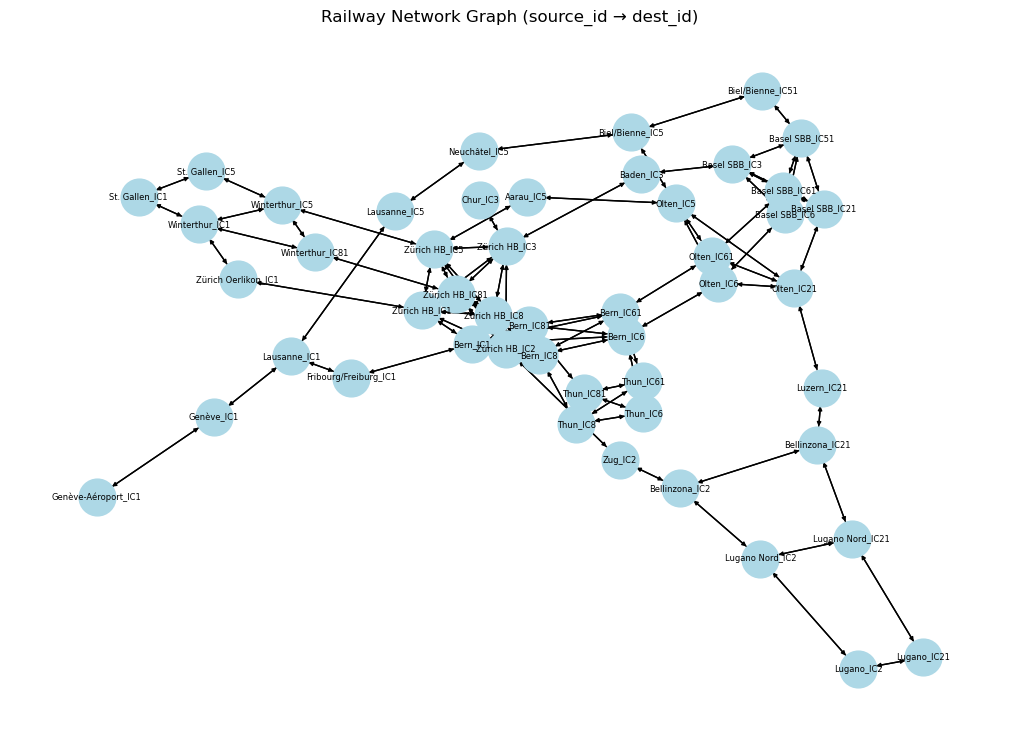

In [12]:
G = nx.DiGraph()

for _, row in df_network.iterrows():
    G.add_edge(row['source_id'], row['dest_id'], weight=row['travel_time'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', arrowsize=6, font_size=6)
plt.title('Railway Network Graph (source_id → dest_id)')
plt.show()

### All or nothing assignment 

Since we have modeled our network with all these seperate nodes and edges to represent transfers, we can easily use the label correction algorithm used for standard traffic assignment 

In [13]:
def label_correction(t, r, n_node, outflow_link_frst, outflow_link_lst, end_node):
    
    """
    Generate shortest path tree from a given origin node using label correction

    :param t: link cost 
    :param r: origin node index
    :param n_node: number of nodes

    :param outflow_link_frst (outflow_link_lst): list of first (last) outflow link indices for each node
    :param end_node: list of end node indices for each link

    :return u: node label
    :return p: previous link on shortest path for each node
    """

    # initialize
    u = np.inf * np.ones(n_node)
    u[r] = 0
    p = -1 * np.ones(n_node, dtype=int)
    Q = queue.Queue()
    Q.put(r) 

    while Q.qsize() > 0 :

        node_i = Q.get() 

        link_frst = outflow_link_frst[node_i]
        link_lst = outflow_link_lst[node_i]
        
        for link in range(link_frst, link_lst + 1):

            node_j = end_node[link]

            if u[node_j] > u[node_i] + t[link] :

                u[node_j] = u[node_i] + t[link]
                p[node_j] = link
                Q.put(node_j)


    return u, p

In [14]:
def prepare_for_dijkstra(network_df):
    """Prepare network data for Dijkstra algorithm"""
    
    network_df = network_df.sort_values(['source_id', 'dest_id']).reset_index(drop=True)
    network_df['link_index'] = network_df.index
    grouped = network_df.groupby('source_id')['link_index'].agg(['min', 'max']).reset_index()
    node_df = pd.DataFrame({
        'node_id': grouped['source_id'],
        'frst_out': grouped['min'],
        'lst_out': grouped['max']
    })
    
    node_to_idx = {node: idx for idx, node in enumerate(node_df['node_id'])}
    end_node_indices = np.array([node_to_idx.get(node, -1) for node in network_df['dest_id']])
    
    # Create station to node mapping for flexible querying
    station_to_nodes = {}
    for node_id in node_df['node_id']:
        if '_' in node_id:
            station = node_id.split('_')[0]
            if station not in station_to_nodes:
                station_to_nodes[station] = []
            station_to_nodes[station].append(node_id)
    
    return node_df, node_to_idx, end_node_indices, network_df, station_to_nodes

In [15]:
node_df, node_to_idx, end_node_indices, network_df = prepare_for_dijkstra(df_network)

node_df.head()

,node_id,frst_out,lst_out
0,Aarau_IC5,0,1
1,Baden_IC3,2,3
2,Basel SBB_IC21,4,8
3,Basel SBB_IC3,9,13
4,Basel SBB_IC51,14,18


In [24]:
network_df.head()

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,travel_time,source_line,dest_line,source_id,dest_id,link_index
0,Aarau,Olten,13373.404,IC5,False,NaN,17.530053,IC5,IC5,Aarau_IC5,Olten_IC5,0
1,Aarau,Zürich HB,41492.905,IC5,False,NaN,38.619679,IC5,IC5,Aarau_IC5,Zürich HB_IC5,1
2,Baden,Basel SBB,83614.363,IC3,False,NaN,70.210772,IC3,IC3,Baden_IC3,Basel SBB_IC3,2
3,Baden,Zürich HB,22587.175,IC3,False,NaN,24.440381,IC3,IC3,Baden_IC3,Zürich HB_IC3,3
4,Basel SBB,Basel SBB,0.000,TRANSFER_IC21_to_IC3,True,20.0,20.000000,IC21,IC3,Basel SBB_IC21,Basel SBB_IC3,4


In [16]:
node_df, node_to_idx, end_node_indices, network_df = prepare_for_dijkstra(df_network)

n_node = len(node_df)
outflow_link_frst = node_df['frst_out'].values
outflow_link_lst = node_df['lst_out'].values
link_costs = network_df['travel_time'].values

origin_station = "Lausanne"

origin_line = "IC1"

origin_node_id = f"{origin_station}_{origin_line}"

origin_idx = node_to_idx[origin_node_id]

u, p = label_correction(link_costs, origin_idx, n_node, outflow_link_frst, outflow_link_lst, end_node_indices)

In [17]:
u

array([183.29906675, 229.97600675, 215.60605125, 215.60605125,
       195.60605125, 201.2651915 , 201.2651915 , 387.57556775,
       368.611729  ,  87.66618375, 107.66618375, 107.66618375,
       107.66618375, 107.66618375, 113.21605775, 133.21605775,
       300.092177  ,  56.8337625 ,  64.6086135 ,  52.6699725 ,
         0.        ,  20.        , 416.74686425, 397.7830255 ,
       424.74181475, 405.777976  , 233.7119635 ,  83.81596775,
       184.38589375, 165.76901375, 164.38589375, 164.38589375,
       270.98043225, 283.48043225, 138.61419275, 138.61419275,
       138.61419275, 138.61419275, 220.62615075, 233.12615075,
       233.12615075, 234.732899  , 185.5356255 , 205.5356255 ,
       205.5356255 , 205.5356255 , 205.5356255 , 205.5356255 ,
       197.06193825])

In [18]:
p

array([100, 161,  14,  15,  68, 105, 110, 146,  91,  71,  35,  36,  37,
        38,  93,  65, 162,  76,  74,  77,  -1,  78,  30,  33,  83,  86,
        96,  80, 107,  67,  45,  51, 135, 139,  46,  52,  57,  63, 188,
       169, 182, 155,  40, 149, 150, 151,  58,  64, 154])

In [19]:
def all_or_nothing_assignment(df_od, df_node, df_link, t):

    """
    All-or-nothing assignment:
    load traffic flows on shortest paths

    :param df_od, df_node, df_link: network data frames
    :param t: link cost

    :return x: link flow
    """

    # initialize link flows
    n_link = len(df_link)
    x = np.zeros(n_link)

    org = np.unique(df_od.org.values)
    n_org = len(org)
    
    for i in range(n_org):
        
        # solve shortest path tree from node i
        u, p = label_correction(df_node, df_link, t, org[i])

        # assign traffic flows by OD
        df_i = df_od.loc[df_od.org == org[i]]
        dest = df_i.dest.values
        q = df_i.q.values
        n_od = len(dest)
        
        for j in range(n_od):
            # last link to destination
            end_node = dest[j]
            idx_link = p[end_node]
            start_node = df_link.start_node.values[idx_link]

            while start_node != org[i]:
                # add demand to link flow
                x[idx_link] += q[j]
                end_node = start_node
                idx_link = p[end_node]
                start_node = df_link.start_node.values[idx_link]

            x[idx_link] += q[j] # add demand to first link

    return x
                    

In [20]:
network_df

,start_node,end_node,distance [m],IC_lines,is_transfer,transfer_time,travel_time,source_line,dest_line,source_id,dest_id,link_index
0,Aarau,Olten,13373.404,IC5,False,NaN,17.530053,IC5,IC5,Aarau_IC5,Olten_IC5,0
1,Aarau,Zürich HB,41492.905,IC5,False,NaN,38.619679,IC5,IC5,Aarau_IC5,Zürich HB_IC5,1
2,Baden,Basel SBB,83614.363,IC3,False,NaN,70.210772,IC3,IC3,Baden_IC3,Basel SBB_IC3,2
3,Baden,Zürich HB,22587.175,IC3,False,NaN,24.440381,IC3,IC3,Baden_IC3,Zürich HB_IC3,3
4,Basel SBB,Basel SBB,0.000,TRANSFER_IC21_to_IC3,True,20.0,20.000000,IC21,IC3,Basel SBB_IC21,Basel SBB_IC3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
185,Zürich HB,Zürich HB,0.000,TRANSFER_IC81_to_IC3,True,20.0,20.000000,IC81,IC3,Zürich HB_IC81,Zürich HB_IC3,185
186,Zürich HB,Zürich HB,0.000,TRANSFER_IC81_to_IC5,True,20.0,20.000000,IC81,IC5,Zürich HB_IC81,Zürich HB_IC5,186
187,Zürich HB,Zürich HB,0.000,TRANSFER_IC81_to_IC8,True,20.0,20.000000,IC81,IC8,Zürich HB_IC81,Zürich HB_IC8,187
188,Zürich Oerlikon,Winterthur,21418.950,IC1,False,NaN,23.564213,IC1,IC1,Zürich Oerlikon_IC1,Winterthur_IC1,188


In [21]:
df_od.head()

,od_id,org,dest,q
0,0,Bern,Basel SBB,3671.0
1,1,Bern,Lausanne,1935.0
2,2,Bern,Luzern,9477.0
3,3,Bern,St. Gallen,924.0
4,4,Bern,Winterthur,3344.0


In [23]:
node_df

,node_id,frst_out,lst_out
0,Aarau_IC5,0,1
1,Baden_IC3,2,3
2,Basel SBB_IC21,4,8
3,Basel SBB_IC3,9,13
4,Basel SBB_IC51,14,18
5,Basel SBB_IC6,19,23
6,Basel SBB_IC61,24,28
7,Bellinzona_IC2,29,31
8,Bellinzona_IC21,32,34
9,Bern_IC1,35,40


In [22]:
all_or_nothing_assignment(df_od, node_df, network_df, network_df['travel_time'])

TypeError: label_correction() missing 2 required positional arguments: 'outflow_link_lst' and 'end_node'